# Apuntes Autoguiados — Stock Market Analysis con Python

**Propósito:** aprender (y re-aprender) *sin contexto externo* cómo analizar acciones con Python.  
**Fecha:** 2025-09-22 (UTC)

## Cómo usar estos apuntes
- Cada módulo sigue este patrón: **Qué aprenderás → Por qué importa → Pasos guiados → Tu turno (TODO) → Solución → Comprobación → Errores comunes → Checklist de memoria**.
- El cuaderno es **autocontenido**: incluye generador de datos sintéticos si no tienes internet/CSV.
- Ejecuta las celdas en orden. Intenta resolver los **TODO** antes de mirar la solución.
- Guarda tus notas: añade comentarios `# tu nota:` en las celdas.


---
## Requisitos mínimos
- Python 3.x, `pandas`, `numpy`, `matplotlib`. (Opcional: `mplfinance`, `statsmodels`).

### Estructura de datos esperada
DataFrames por *ticker* con columnas: `Open, High, Low, Close, Volume` e índice `DatetimeIndex`.

> Si no tienes CSV ni conexión, usa el **generador sintético** incluido.


## 0) Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline  # Descomenta si usas Jupyter clásico
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")
print("OK: entorno listo. pandas", pd.__version__)

OK: entorno listo. pandas 2.3.2


## 1) Datos — Cargar o Generar (Autocontenido)

### Qué aprenderás
- Crear un DataFrame financiero estándar (OHLCV).
- Cargar desde CSV *o* generar datos **sintéticos**.
- Asegurar un rango temporal consistente.

### Por qué importa
Tener datos limpios y coherentes evita errores río abajo (gráficos engañosos, retornos mal calculados).

### Pasos guiados
1. Intenta `load_csv("TSLA.csv")` etc.
2. Si falla, usa `make_synthetic("TSLA")`.
3. Recorta al rango de interés.


In [2]:
from pathlib import Path


def load_csv(fname: str):
    """Carga un CSV con columnas: Date, Open, High, Low, Close, Volume"""
    p = Path(fname)
    if not p.exists():
        return None
    df = pd.read_csv(p, parse_dates=["Date"]).set_index("Date").sort_index()
    df = df.rename(columns={c: c.strip().title() for c in df.columns})
    return df[["Open","High","Low","Close","Volume"]]


def make_synthetic(ticker: str, start="2012-01-01", end="2017-01-01", seed=0):
    """Genera OHLCV realista para practicar sin datos reales."""
    rng = np.random.default_rng(abs(hash(ticker)) % (2**32) + seed)
    idx = pd.date_range(start, end, freq="B")
    n = len(idx)
    drift = {"TSLA": 0.0008, "GM": 0.0002, "F": 0.00015}.get(ticker, 0.0003)
    vol   = {"TSLA": 0.0300, "GM": 0.0150, "F": 0.0120}.get(ticker, 0.0200)
    log_ret = rng.normal(drift, vol, size=n)
    base = 20 * np.exp(np.cumsum(log_ret))
    open_ = base
    high = open_ * (1 + rng.normal(0.001, 0.01, size=n).clip(-0.02, 0.05))
    low  = open_ * (1 - rng.normal(0.001, 0.01, size=n).clip(-0.05, 0.02))
    close= open_ * (1 + rng.normal(0, 0.01, size=n))
    volume = rng.integers(1e6, 5e6, size=n)
    df = pd.DataFrame({'Open':open_, 'High':high, 'Low':low, 'Close':close, 'Volume':volume}, index=idx)
    df.index.name = "Date"
    return df


def get_ticker(ticker: str, csv_name: str, start="2012-01-01", end="2017-01-01"):
    df = load_csv(csv_name)
    if df is None or df.empty:
        print(f"[{ticker}] CSV no encontrado → usando datos sintéticos.")
        df = make_synthetic(ticker, start, end)
    return df.loc[start:end]

TSLA = get_ticker("TSLA", "TSLA.csv")
GM   = get_ticker("GM",   "GM.csv")
F    = get_ticker("F",    "F.csv")

TSLA.head(3)

[TSLA] CSV no encontrado → usando datos sintéticos.
[GM] CSV no encontrado → usando datos sintéticos.
[F] CSV no encontrado → usando datos sintéticos.


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-02,19.270519,19.238258,19.380086,19.073407,3114872
2012-01-03,18.753329,18.484666,18.579513,18.687101,1746714
2012-01-04,17.562905,17.661816,17.392117,17.614470,2273310


## 2) Visualización base (Open, Volume, TotalTraded)

### Qué aprenderás
- Graficar series comparables y no comparables.
- Detectar spikes de volumen.
- Entender por qué *precio* ≠ *capitalización*.

### Tu turno (TODO)
Completa la función `plot_open_three` y `plot_volume_three`.


In [3]:
# TODO: implementa las dos funciones. Ejecuta luego la celda de prueba.

def plot_open_three(tsla, gm, ford):
    plt.figure(figsize=(14,6))
    tsla['Open'].plot(label='TSLA')
    gm['Open'].plot(label='GM')
    ford['Open'].plot(label='F')
    plt.title('Precio de Apertura')
    plt.legend(); plt.tight_layout()


def plot_volume_three(tsla, gm, ford):
    plt.figure(figsize=(14,6))
    tsla['Volume'].plot(label='TSLA')
    gm['Volume'].plot(label='GM')
    ford['Volume'].plot(label='F')
    plt.title('Volumen Diario')
    plt.legend(); plt.tight_layout()

**Interpretation:**  
- **Open:** lets you compare price levels, but remember this does not reflect company size (market cap).  
- **Volume:** spikes usually indicate news, earnings, or unusual activity.  
- **TotalTraded:** approximates money exchanged (Open × Volume). Compare across stocks to see where most capital flows.


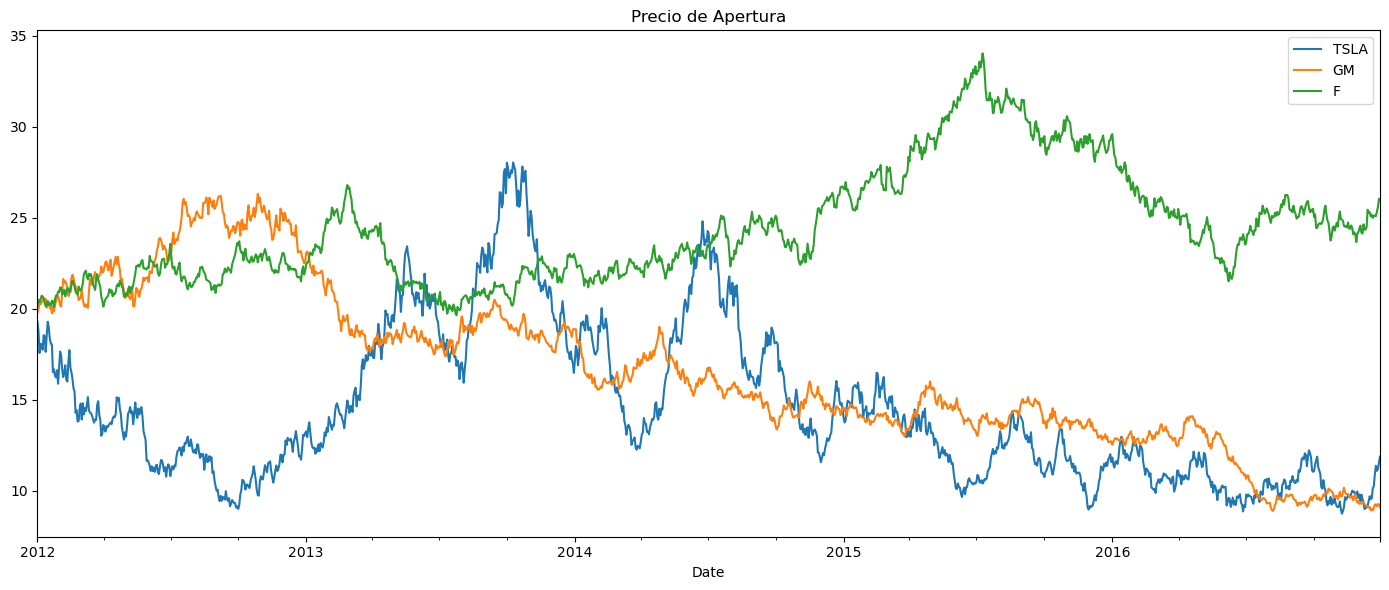

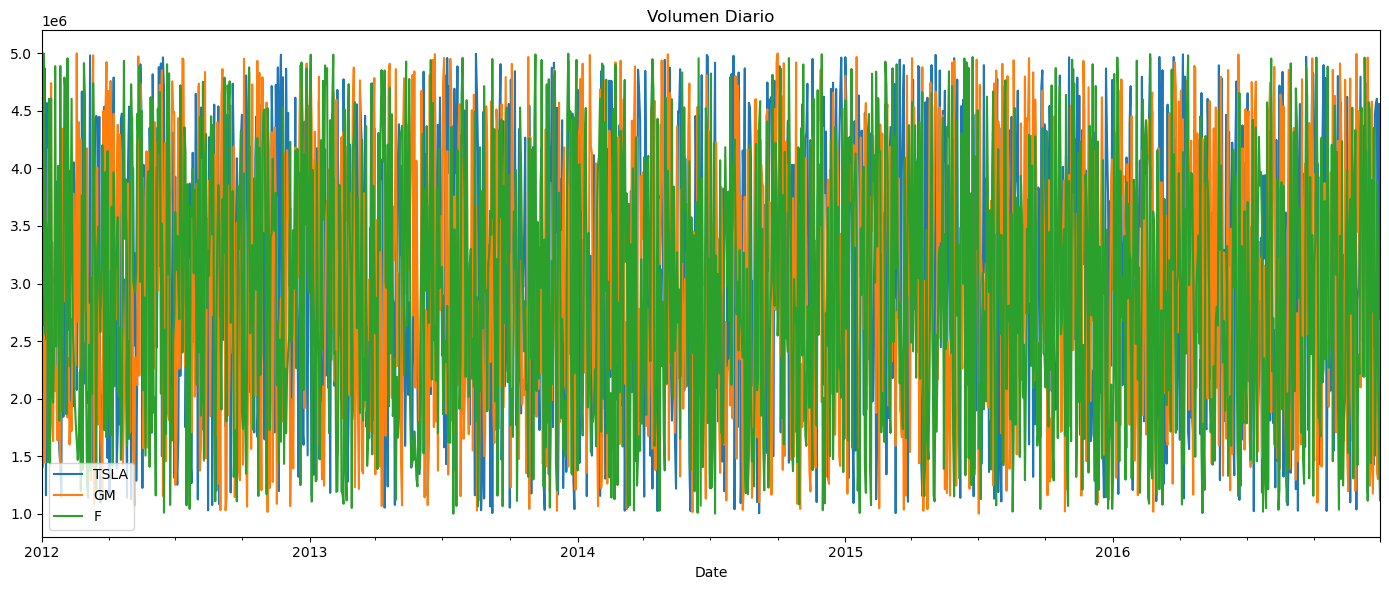

In [4]:
plot_open_three(TSLA, GM, F)
plot_volume_three(TSLA, GM, F)

### Solución explicada
- **Open** permite comparar niveles de precio, pero ignora cuántas acciones existen.  
- **Volume** ayuda a localizar días con eventos/noticias.

**TotalTraded** (aprox. dinero movido): `Open × Volume` (no es market cap).

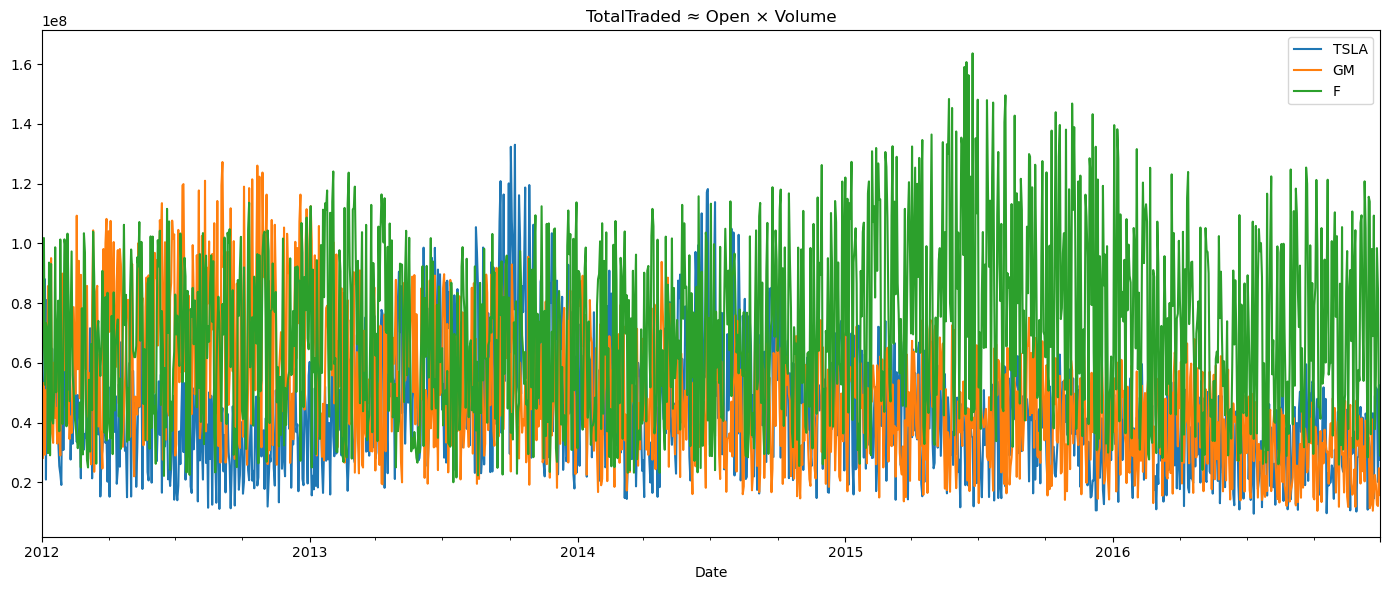

In [5]:
for df in (TSLA, GM, F):
    df['TotalTraded'] = df['Open'] * df['Volume']

plt.figure(figsize=(14,6))
TSLA['TotalTraded'].plot(label='TSLA')
GM['TotalTraded'].plot(label='GM')
F['TotalTraded'].plot(label='F')
plt.title('TotalTraded ≈ Open × Volume'); plt.legend(); plt.tight_layout()

## 3) Medias móviles (MA) y estructura

### Qué aprenderás
- Calcular MA(50) y MA(200) en `Open`.
- Razón: suavizar ruido para ver tendencia/estructura.

### Tu turno (TODO)
Implementa `add_ma(df, windows)` que agregue columnas `MA_{w}`.


**Observation:**  
- When MA(50) crosses above MA(200), it’s often called a **Golden Cross** (bullish signal).  
- When MA(50) crosses below MA(200), it’s a **Death Cross** (bearish signal).  
These crossovers are commonly used by technical traders as trend confirmation.


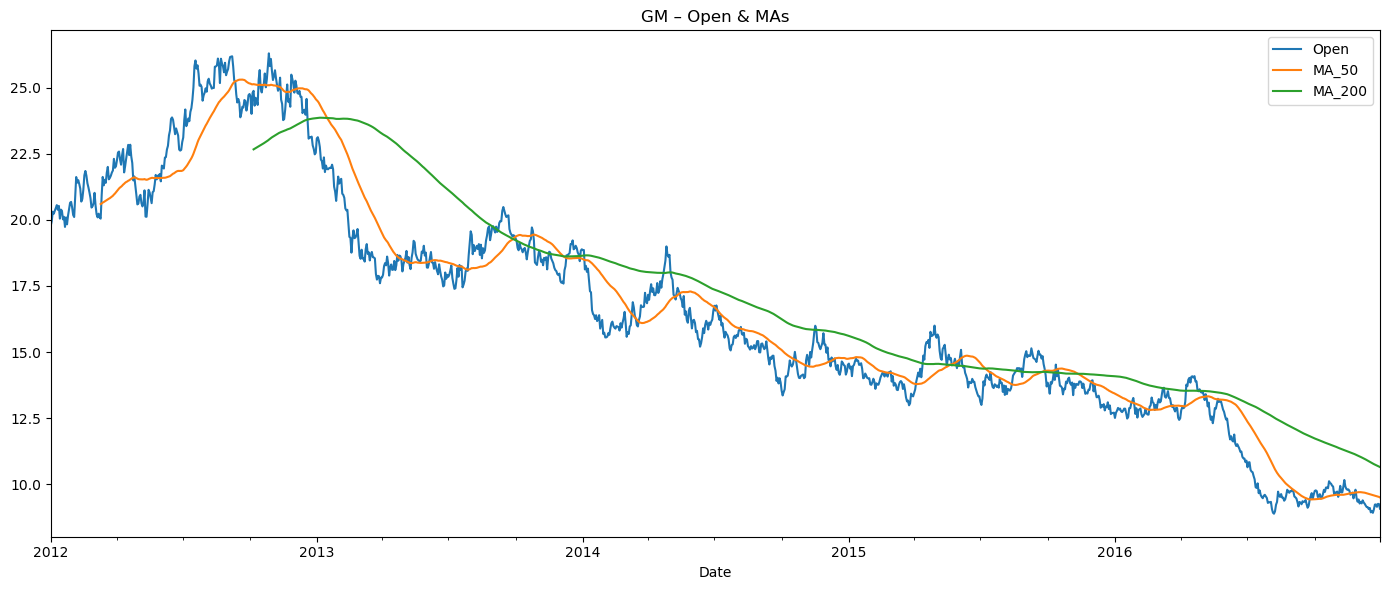

In [6]:
def add_ma(df: pd.DataFrame, windows=(50, 200)):
    for w in windows:
        df[f'MA_{w}'] = df['Open'].rolling(w).mean()
    return df

GM = add_ma(GM, windows=(50,200))
GM[['Open','MA_50','MA_200']].plot(figsize=(14,6), title='GM – Open & MAs'); plt.tight_layout()

## 4) Retornos diarios y volatilidad

### Qué aprenderás
- Retorno: $ r_t = \frac{P_t}{P_{t-1}} - 1 $ (usaremos `Close`).
- `pct_change()` de pandas.
- Medir volatilidad con histogramas/KDE/boxplots.

### Tu turno (TODO)
Implementa `add_returns(df)` → añade columna `Return`.


**Interpretation:**  
- The wider the histogram/KDE curve, the higher the volatility (risk).  
- If the distribution is skewed or has fat tails, it may indicate higher probability of extreme returns.  
Always compare multiple assets: a tighter curve means more stable returns.


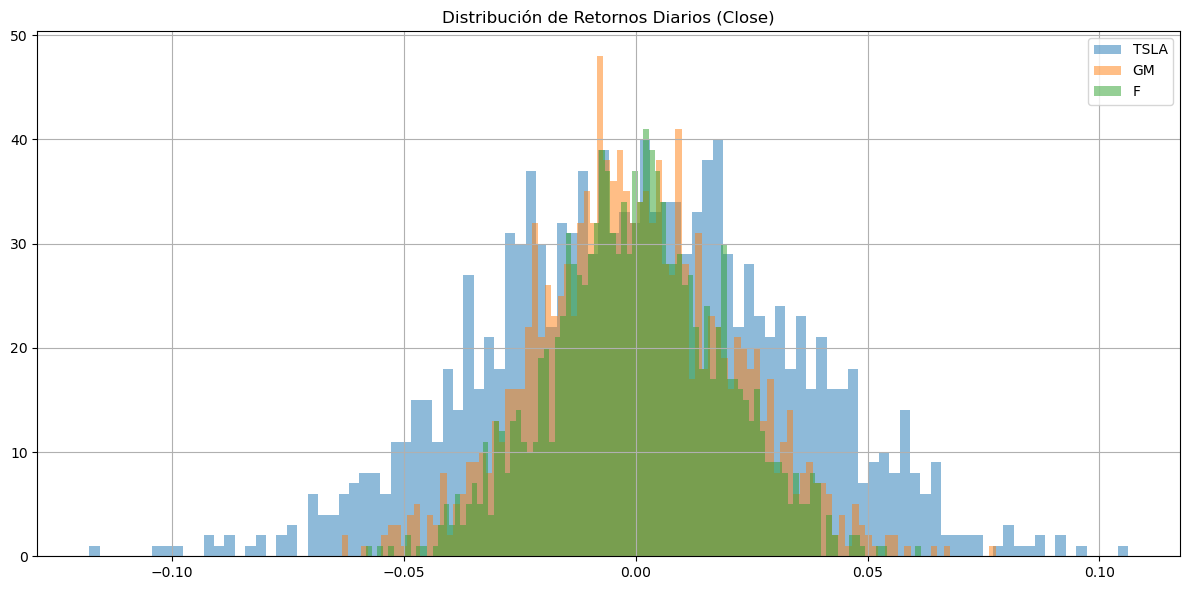

In [7]:
def add_returns(df: pd.DataFrame, price_col='Close'):
    df['Return'] = df[price_col].pct_change()
    return df

TSLA = add_returns(TSLA)
GM   = add_returns(GM)
F    = add_returns(F)

plt.figure(figsize=(12,6))
for name, d in [('TSLA', TSLA), ('GM', GM), ('F', F)]:
    d['Return'].hist(bins=100, alpha=0.5, label=name)
plt.title('Distribución de Retornos Diarios (Close)'); plt.legend(); plt.tight_layout()

**Interpretation:**  
- A tight cloud along a diagonal indicates strong correlation.  
- A diffuse or round cloud indicates weak or no correlation.  
Understanding correlations is crucial for portfolio diversification: assets with low correlation reduce overall risk.


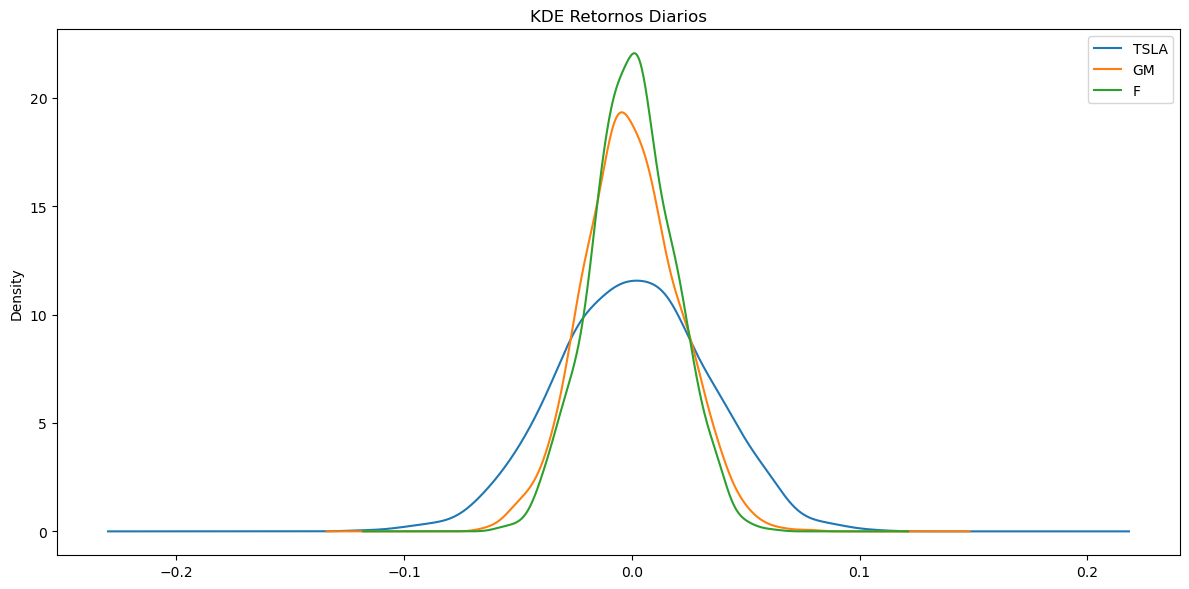

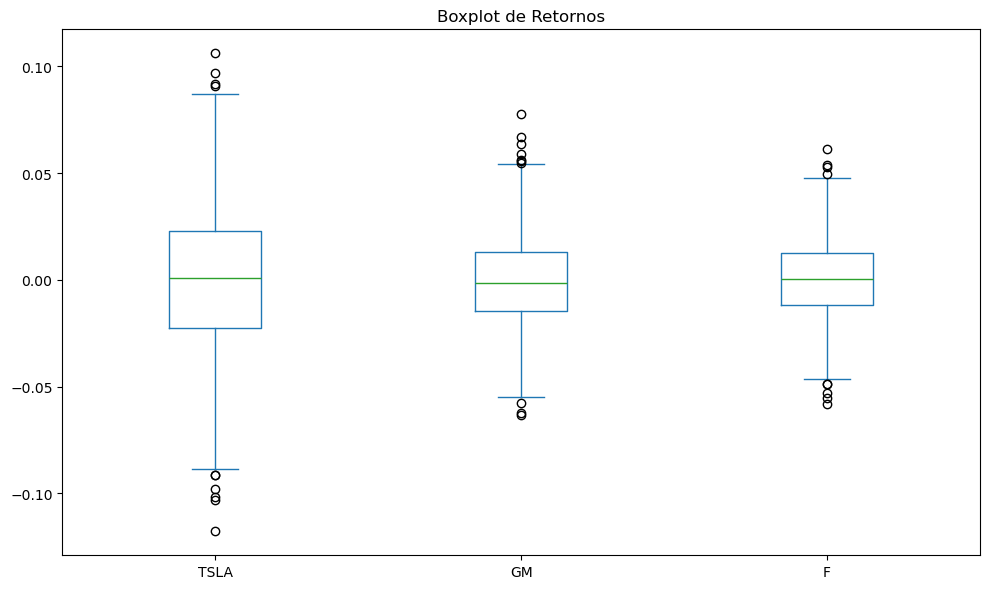

In [8]:
plt.figure(figsize=(12,6))
TSLA['Return'].plot(kind='kde', label='TSLA')
GM['Return'].plot(kind='kde', label='GM')
F['Return'].plot(kind='kde', label='F')
plt.title('KDE Retornos Diarios'); plt.legend(); plt.tight_layout()

box_df = pd.concat([
    TSLA['Return'].rename('TSLA'),
    GM['Return'].rename('GM'),
    F['Return'].rename('F')
], axis=1)

box_df.plot(kind='box', figsize=(10,6), title='Boxplot de Retornos'); plt.tight_layout()

## 5) Correlaciones de retornos

### Qué aprenderás
- Visualizar relaciones lineales entre retornos.
- Distinguir pares correlacionados vs. independientes.

### Tu turno (TODO)
Crea un *scatter* de `Return` de F (X) vs GM (Y).


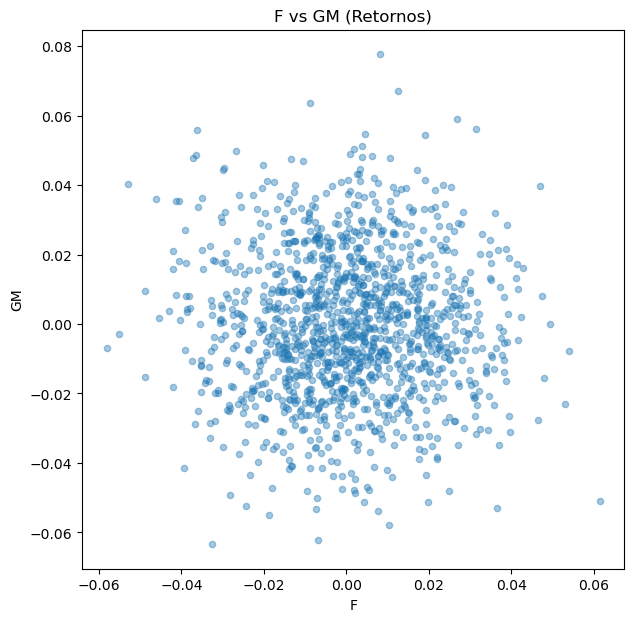

In [9]:
ax = box_df.plot(kind='scatter', x='F', y='GM', figsize=(7,7), alpha=0.4, title='F vs GM (Retornos)')

## 6) Cumulative Daily Returns (CDR)

### Qué aprenderás
- Evolución de $1 invertido:  $ $ \text{CDR}_t = \prod_{i=1}^{t} (1 + r_i) $. 
- Interpretar curvas de crecimiento acumulado.

### Tu turno (TODO)
Implementa `add_cdr(df)` que añada `CDR`.


**Observation:**  
- The CDR curve shows how $1 invested grows over time.  
- Steeper slopes mean higher growth; flat or downward slopes mean stagnation or loss.  
Comparing multiple stocks reveals which would have been the best long-term investment.


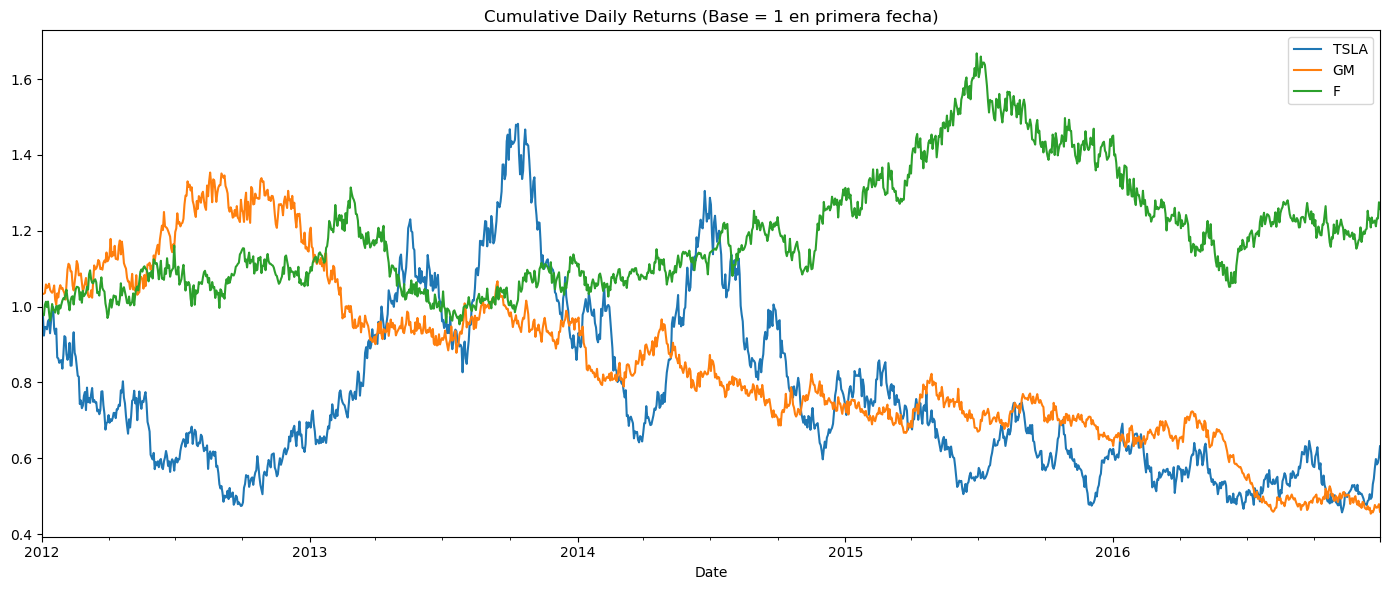

In [10]:
def add_cdr(df: pd.DataFrame, ret_col='Return'):
    df['CDR'] = (1 + df[ret_col]).cumprod()
    return df

TSLA = add_cdr(TSLA); GM = add_cdr(GM); F = add_cdr(F)

plt.figure(figsize=(14,6))
TSLA['CDR'].plot(label='TSLA')
GM['CDR'].plot(label='GM')
F['CDR'].plot(label='F')
plt.title('Cumulative Daily Returns (Base = 1 en primera fecha)')
plt.legend(); plt.tight_layout()

In [11]:
cdr_end = pd.Series({
    'TSLA': TSLA['CDR'].dropna().iloc[-1],
    'GM':   GM['CDR'].dropna().iloc[-1],
    'F':    F['CDR'].dropna().iloc[-1],
}).sort_values(ascending=False)
print("CDR final (mayor→menor):\n", cdr_end.to_frame('CDR_final'))

CDR final (mayor→menor):
       CDR_final
F      1.257522
TSLA   0.631509
GM     0.458793


## 7) Bonus (Opcional)

### 7.1 Candlesticks (requiere `mplfinance`)

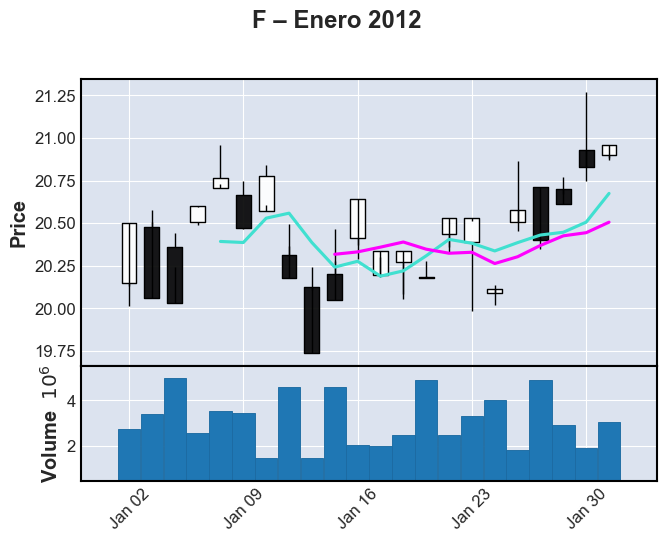

In [12]:
try:
    import mplfinance as mpf
    F_2012_01 = F.loc['2012-01-01':'2012-01-31'][['Open','High','Low','Close','Volume']]
    mpf.plot(F_2012_01, type='candle', mav=(5,10), volume=True, title='F – Enero 2012')
except Exception as e:
    print("Candlestick omitido (instala 'mplfinance'). Error:", e)

### 7.2 Conceptos de Series Temporales
- **Trend** (tendencia), **Seasonality** (estacionalidad), **Cyclic** (cíclico).

#### Demo: Filtro de Hodrick–Prescott (si tienes `statsmodels`)

/Users/rodrigojimenez/anaconda3/envs/pyfinance/lib/python3.11/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


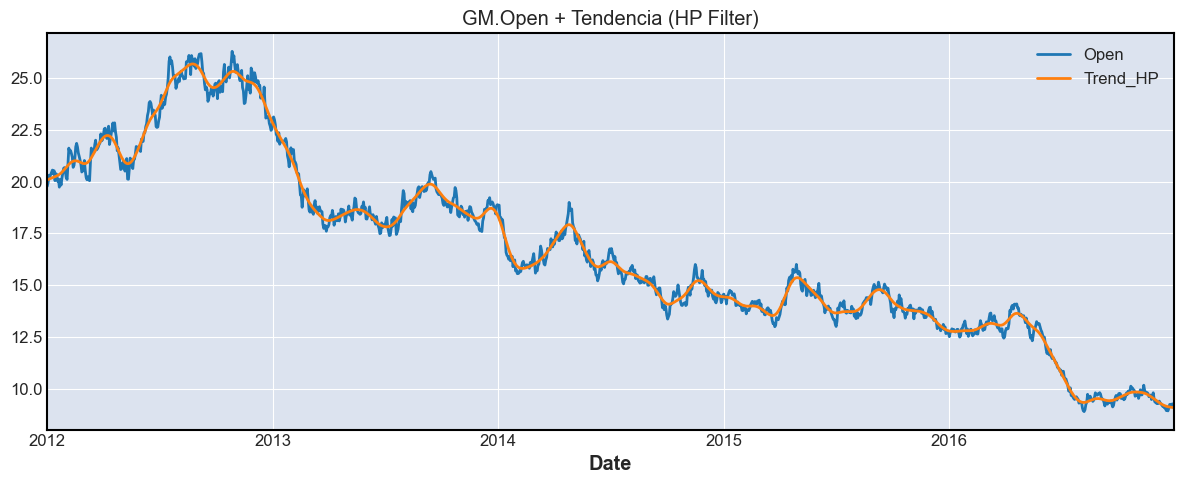

In [13]:
try:
    import statsmodels.api as sm
    cycle, trend = sm.tsa.filters.hpfilter(GM['Open'].dropna(), lamb=1600)
    trend.name = 'Trend_HP'
    pd.concat([GM['Open'], trend], axis=1).plot(figsize=(12,5), title='GM.Open + Tendencia (HP Filter)')
    plt.tight_layout()
except Exception as e:
    print("HP Filter omitido (instala 'statsmodels'). Error:", e)

## 8) Glosario esencial
- **OHLCV:** Open, High, Low, Close, Volume.
- **MA(w):** Media móvil de ventana `w` días.
- **Retorno diario:** Cambio porcentual día a día (proporción).
- **Volatilidad:** Dispersión de retornos; histograma más ancho = más riesgo.
- **CDR:** Crecimiento de una inversión acumulando retornos.
- **Correlación:** Relación lineal entre variables (∈ [-1,1]).
- **HP Filter:** Método para separar tendencia y ciclo.

## 9) Checklist final (¿puedo hacerlo sin mirar?)
- [ ] Cargar o generar datos OHLCV limpios.
- [ ] Graficar `Open`, `Volume` y **TotalTraded**.
- [ ] Calcular MA(50)/MA(200) y explicar su diferencia.
- [ ] Calcular `Return`, interpretar histogramas/KDE/boxplots.
- [ ] Medir correlaciones y leer un *scatter*.
- [ ] Construir y explicar `CDR`.
- [ ] (Opcional) Hacer un candlestick de un subperiodo.


# 📚 Summary — Guided Stock Market Analysis

- Clean data before any analysis (OHLCV format, DateTimeIndex).
- Use **Open/Volume/TotalTraded** to spot unusual trading days.
- Apply **Moving Averages** to reveal medium/long-term trends.
- Compute **daily returns** and analyze their distribution (risk profile).
- Study **correlations** to build diversified portfolios.
- Use **Cumulative Returns** to evaluate long-term performance.

> **Key takeaway:** These tools form the foundation of quantitative finance.  
> They allow you to compare assets, measure risk, and design trading or investment strategies with data, not intuition.
